# Volatility Surface Construction – Notebook 5
## Model Calibration

### 5.1 Introduction

Calibration is the process of finding the model parameters $\theta$ that minimize the difference between the model-implied volatility $\sigma_{model}$ and the market-observed volatility $\sigma_{market}$. This is an optimization problem—specifically, a **Least Squares** problem:

$$ \hat{\theta} = \arg\min_{\theta} \sum_{i} w_i \left( \sigma_{model}(K_i, \theta) - \sigma_{market}(K_i) \right)^2 $$

In this notebook, we utilize the calibration engine defined in `src/calibration.py` to fit both the SVI and SABR models to the SPY option data.

### 5.2 The Calibration Engine

Key components of the engine include:

**1. `CalibrationResult` Data Class**
To avoid passing raw optimizer outputs, the module returns a standardized `CalibrationResult` object containing:
* `params`: A dictionary of fitted parameters (e.g., `{'a': 0.04, ...}`).
* `cost`: The final value of the objective function (sum of squared residuals).
* `success`: Boolean flag indicating if the optimizer converged.

**2. Objective Functions**
The module defines distinct loss functions for each model:
* **SVI:** Optimizes **Total Variance** ($w$). This is numerically more stable for SVI than optimizing volatility directly.
* **SABR:** Optimizes **Implied Volatility** ($\sigma_{imp}$) directly, as the Hagan formula outputs volatility.

**3. Optimizer**
We use `scipy.optimize.least_squares`, which is robust to outliers and, crucially, allows us to set hard bounds (constraints) on parameters (e.g., $\rho \in [-1, 1]$).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Ensure local modules can be imported
sys.path.append(str(Path.cwd().parent))

from src.calibration import calibrate_svi, calibrate_sabr
from src.SVI import svi_implied_vol, SVIParams
from src.SABR import sabr_implied_vol

### 5.3 Data Preparation

We load the processed options data from `src/options_data.csv`. For this demonstration, we will select a single maturity slice ($T$) to visualize the calibration performance in detail.

In [2]:
# Load data
csv_path = Path.cwd().parent / "src" / "options_data.csv"
df = pd.read_csv(csv_path)

# Select a specific maturity slice (e.g., closest to 3 months)
target_maturity = 0.25
slice_df = df.iloc[(df['T'] - target_maturity).abs().argsort()[:1]].copy()
selected_expiry = slice_df['expiration_date'].values[0]

# Filter the full dataframe for this specific expiration
calibration_slice = df[df['expiration_date'] == selected_expiry].sort_values("strike")

print(f"Selected Expiration: {selected_expiry}")
print(f"Time to Maturity (T): {calibration_slice['T'].iloc[0]:.4f} years")
print(f"Number of strikes: {len(calibration_slice)}")

Selected Expiration: 2026-04-30
Time to Maturity (T): 0.2384 years
Number of strikes: 49


### 5.4 Calibrating SVI

We now fit the SVI model. We must provide an **initial guess** ($x_0$) and **bounds** to guide the optimizer.

**Bounds:**
* $b \ge 0$ (Non-negative slope)
* $|\rho| < 1$ (Correlation)
* $\sigma > 0$ (Positive curvature)

In [3]:
# Prepare inputs
log_moneyness = calibration_slice["log_moneyness"].values
market_iv = calibration_slice["impliedVolatility"].values
T = calibration_slice["T"].iloc[0]

# Initial Guess: [a, b, rho, m, sigma]
svi_guess = np.array([0.04, 0.1, -0.5, 0.0, 0.1])

# Bounds: ([lowers], [uppers])
svi_bounds = (
    [-np.inf, 0.0, -0.999, -np.inf, 0.001],  # Lower bounds
    [np.inf, 5.0, 0.999, np.inf, 5.0]       # Upper bounds
)

# Run Calibration
svi_result = calibrate_svi(
    log_moneyness=log_moneyness,
    implied_vol=market_iv,
    maturity=T,
    initial_guess=svi_guess,
    bounds=svi_bounds
)

print("SVI Calibration Result:")
print(f"Success: {svi_result.success}")
print(f"Cost: {svi_result.cost:.6f}")
print(f"Params: {svi_result.params}")

SVI Calibration Result:
Success: True
Cost: 0.000120
Params: {'a': np.float64(-0.24825189359843924), 'b': np.float64(0.051968555101677506), 'rho': np.float64(-0.5404000901153536), 'm': np.float64(3.4355278212395244), 'sigma': np.float64(0.001016601842461612)}


### 5.5 Calibrating SABR

Next, we fit the SABR model. A crucial decision here is the choice of $\beta$ (Beta). In equity markets, it is difficult to distinguish $\beta$ from $\rho$ using only a single smile. Therefore, it is standard practice to **fix $\beta=1.0$** (Stochastic Log-Normal) or $\beta=0.5$ and calibrate only $\alpha, \rho, \nu$.

We will fix $\beta=1.0$ for this example.

In [4]:
# Prepare inputs
strikes = calibration_slice["strike"].values
forward_price = calibration_slice["forward_price"].iloc[0]
beta_fixed = 1.0

# Initial Guess: [alpha, rho, nu]
sabr_guess = np.array([0.2, -0.5, 0.5])

# Bounds
sabr_bounds = (
    [0.001, -0.999, 0.001], # Lower
    [5.0, 0.999, 5.0]       # Upper
)

# Run Calibration
sabr_result = calibrate_sabr(
    strikes=strikes,
    implied_vol=market_iv,
    forward=forward_price,
    maturity=T,
    beta=beta_fixed,
    initial_guess=sabr_guess,
    bounds=sabr_bounds
)

print("SABR Calibration Result:")
print(f"Success: {sabr_result.success}")
print(f"Cost: {sabr_result.cost:.6f}")
print(f"Params: {sabr_result.params}")

SABR Calibration Result:
Success: True
Cost: 0.005910
Params: {'alpha': np.float64(0.3447663400954776), 'rho': np.float64(-0.9974308178105904), 'nu': np.float64(1.105864173245505)}


### 5.6 Visual Verification

To verify the quality of the fit, we plot the Market IV against the calibrated SVI and SABR curves. A good fit should capture the smile's depth (ATM) and its skew (wings).

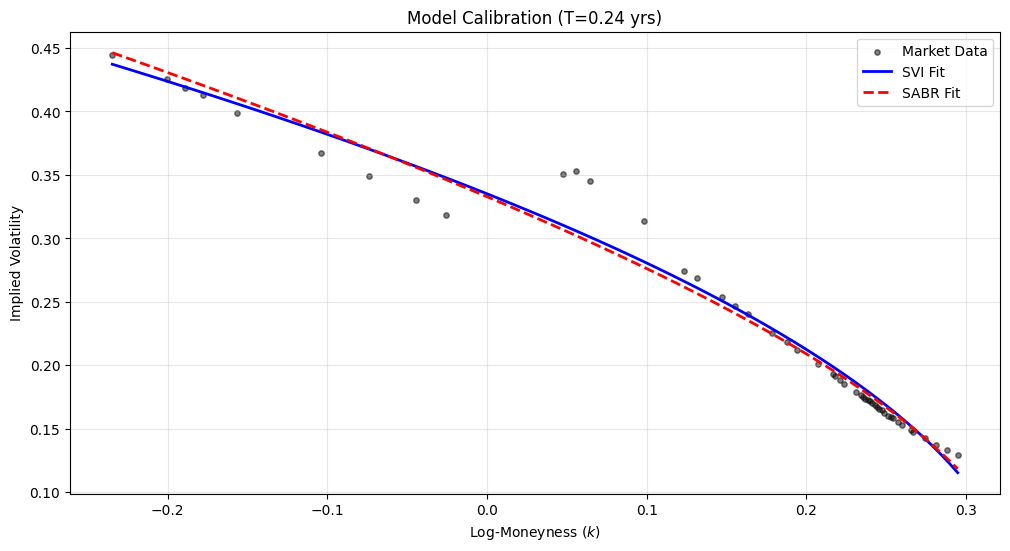

In [5]:
# 1. Generate Model Curves
k_grid = np.linspace(min(log_moneyness), max(log_moneyness), 100)
strikes_grid = forward_price * np.exp(k_grid)

# SVI Curve
svi_params = SVIParams(**svi_result.params)
svi_iv_curve = svi_implied_vol(k_grid, T, svi_params)

# SABR Curve
sabr_iv_curve = sabr_implied_vol(
    forward_price, 
    strikes_grid, 
    T, 
    sabr_result.params['alpha'], 
    beta_fixed, 
    sabr_result.params['rho'], 
    sabr_result.params['nu']
)

# 2. Plotting
plt.figure(figsize=(12, 6))

# Market Data
plt.scatter(log_moneyness, market_iv, color='black', alpha=0.5, label='Market Data', s=15)

# Models
plt.plot(k_grid, svi_iv_curve, color='blue', label='SVI Fit', linewidth=2)
plt.plot(k_grid, sabr_iv_curve, color='red', linestyle='--', label='SABR Fit', linewidth=2)

plt.title(f"Model Calibration (T={T:.2f} yrs)")
plt.xlabel("Log-Moneyness ($k$)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 5.7 Conclusion

In this notebook, we successfully applied the `calibration.py` engine to fit both SVI and SABR models to a real market slice. 

* **SVI** demonstrated flexibility in capturing the broad smile structure.
* **SABR** provided a fit grounded in stochastic dynamics, though constrained by the fixed $\beta$.

While the visual fits appear reasonable, a rigorous analysis requires quantitative metrics. **Notebook 6** will focus on **Diagnostics**, where we will evaluate arbitrage consistency (butterfly spreads) and parameter stability across time.